In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import os
import numpy as np
import matplotlib.pyplot as plt

In [22]:
model_path = '../models/brats_model.h5'

train_dir = '../data/train/t2'
valid_dir = '../data/valid/t2'
train_pos_dir = os.path.join(train_dir, '1')  # directory with our training cat pictures
train_neg_dir = os.path.join(train_dir, '0')

In [3]:
num_pos_tr = len(os.listdir(train_pos_dir))
num_neg_tr = len(os.listdir(train_neg_dir))
total_train = num_pos_tr + num_neg_tr
print('total training positive images:', num_pos_tr)
print('total training negative images:', num_neg_tr)

total training positive images: 9498
total training negative images: 3942


In [4]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 240
IMG_WIDTH = 240

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=45)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [6]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 13440 images belonging to 2 classes.


In [7]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=valid_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 3360 images belonging to 2 classes.


In [8]:
sample_training_images, l = next(val_data_gen)

In [9]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

[1. 1. 1. 1. 1.]


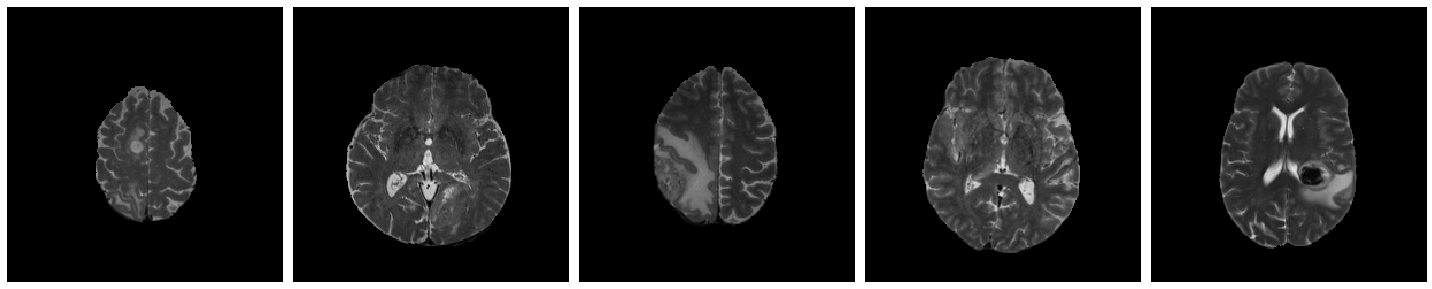

In [10]:
print(l[:5])
plotImages(sample_training_images[:5])

In [19]:
def get_model():
    return Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

In [ ]:
model = get_model()

In [12]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [13]:
model.compile(optimizer=adam,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 120, 120, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0

In [15]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)

# Save the model
model.save(model_path);

Epoch 1/15
105/105 [==============================] - 199s 2s/step - loss: 0.5630 - accuracy: 0.7316 - val_loss: 0.5727 - val_accuracy: 0.7118
Epoch 2/15
105/105 [==============================] - 197s 2s/step - loss: 0.5571 - accuracy: 0.7292 - val_loss: 0.5687 - val_accuracy: 0.7230
Epoch 3/15
105/105 [==============================] - 193s 2s/step - loss: 0.5521 - accuracy: 0.7422 - val_loss: 0.5693 - val_accuracy: 0.7010
Epoch 4/15
105/105 [==============================] - 197s 2s/step - loss: 0.5498 - accuracy: 0.7408 - val_loss: 0.5807 - val_accuracy: 0.6448
Epoch 5/15
105/105 [==============================] - 193s 2s/step - loss: 0.5482 - accuracy: 0.7459 - val_loss: 0.5482 - val_accuracy: 0.7479
Epoch 6/15
105/105 [==============================] - 195s 2s/step - loss: 0.5389 - accuracy: 0.7653 - val_loss: 0.5548 - val_accuracy: 0.7049
Epoch 7/15
105/105 [==============================] - 202s 2s/step - loss: 0.5387 - accuracy: 0.7633 - val_loss: 0.5502 - val_accuracy: 0.7470

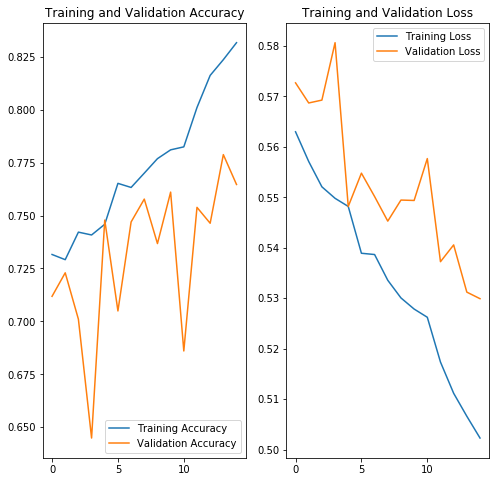

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()